SENTIMENT ANALYSIS

In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

# coverting textual data into digits
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
# dense defines fully connected layer in neural network
# Dropout - percentage of neurons during training
from keras.layers import Activation, Dropout, Dense


from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("/content/a1_IMDB_Dataset (1).csv", skiprows=range(2370, 2380))


In [ ]:
# Dataset exploration

movie_reviews.shape

(2369, 2)

In [ ]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

Data preprocessing

In [ ]:
movie_reviews["review"][2]

# As our text contains punctuations, brackets, HTML tags and numbers


'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
# '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):


    return TAG_RE.sub('', text)

In [ ]:
import nltk
# Stopwards removes words like a ,the, and
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only in lowercase'
def preprocess_text(sen):


    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up movie review

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



Embedding layer

In [ ]:
# Embedding layer expects the words to be in numeric form

# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

24545

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
# UTF-8 encoding is commonly used for handling text data in Python, especially when dealing with non-ASCII characters.
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        if len(embedding_vector) == 100:  # Check if embedding vector has the expected shape
            embedding_matrix[index - 1] = embedding_vector  # Adjust index by 1 if needed
        else:
            print(f"Warning: Embedding vector for '{word}' does not have the expected shape.")


In [ ]:
embedding_matrix.shape

(24545, 100)

Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
# 128 neurons in NN
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

# Adam is an optimization algorithm that is widely used in training neural networks.
# binary_crossentropy - It measures the difference between the true labels and the predicted probabilities for binary classification tasks
# The metric 'acc' stands for accuracy
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2454500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2571877 (9.81 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 2454500 (9.36 MB)
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
12/12 [==============================] - 11s 713ms/step - loss: 0.7080 - acc: 0.4888 - val_loss: 0.7021 - val_acc: 0.5013
Epoch 2/6
12/12 [==============================] - 3s 293ms/step - loss: 0.6937 - acc: 0.5204 - val_loss: 0.6961 - val_acc: 0.4987
Epoch 3/6
12/12 [==============================] - 4s 322ms/step - loss: 0.6893 - acc: 0.5409 - val_loss: 0.6961 - val_acc: 0.4828
Epoch 4/6
12/12 [==============================] - 5s 409ms/step - loss: 0.6877 - acc: 0.5376 - val_loss: 0.6974 - val_acc: 0.4908
Epoch 5/6
12/12 [==============================] - 7s 562ms/step - loss: 0.6866 - acc: 0.5462 - val_loss: 0.6977 - val_acc: 0.5066
Epoch 6/6
12/12 [==============================] - 4s 326ms/step - loss: 0.6830 - acc: 0.5402 - val_loss: 0.6997 - val_acc: 0.4855


In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

15/15 [==============================] - 1s 76ms/step - loss: 0.6888 - acc: 0.5232


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6888293027877808
Test Accuracy: 0.5232067704200745


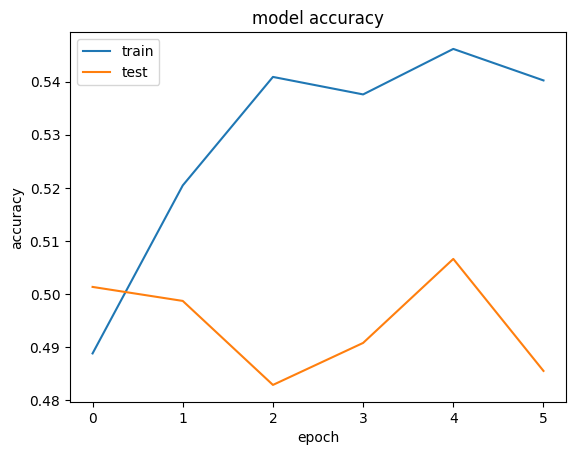

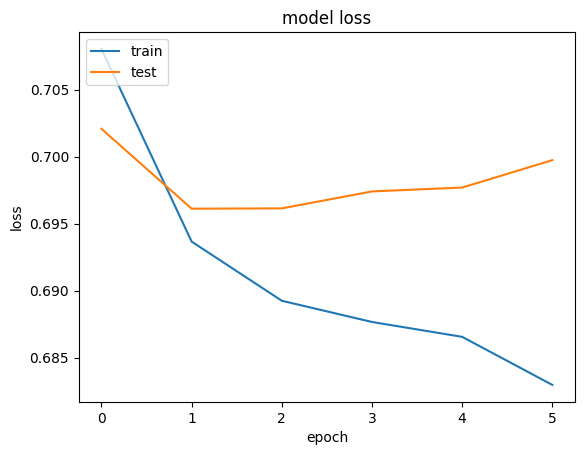

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()